# Pengerjaan Tugas Deep Learning Week 4 Menggunakan Tensorflow

# Tahap Persiapan

## 1. Instalasi Modul yang diperlukan

In [1]:
# !pip install numpy pandas matplotlib scikit-learn tensorflow tensorflow-datasets
%pip install numpy pandas matplotlib scikit-learn tensorflow tensorflow-datasets

Note: you may need to restart the kernel to use updated packages.


## 2. Mengimpor Library yang Dibutuhkan

In [22]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, Dropout, Input, BatchNormalization
from tensorflow.keras.layers import SimpleRNN, LSTM, GRU
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import label_binarize
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, auc, roc_auc_score, roc_curve, confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import io
import re
from collections import Counter
import time

# Memeriksa ketersediaan GPU
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


## 3. Mendefinisikan Parameter dan Pre-processing Dataset IMDb

In [30]:
# Konstanta dan parameter
NUM_WORDS = 40000
MAXLEN = 400
BATCH_SIZE = 128
EMBEDDING_DIM = 128
HIDDEN_DIM = 128
DROPOUT_RATE = 0.33
EPOCHS = 20
LEARNING_RATE = 0.001

print("Memuat dataset IMDb...")
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=NUM_WORDS)

print(f"Jumlah sampel training: {len(x_train)}")
print(f"Jumlah sampel testing: {len(x_test)}")

# Padding sequences
x_train = pad_sequences(x_train, maxlen=MAXLEN, padding='post', truncating='post')
x_test = pad_sequences(x_test, maxlen=MAXLEN, padding='post', truncating='post')

train_data = (x_train, y_train)
test_data = (x_test, y_test)

# Menampilkan beberapa contoh data training
def decode_review(text):
    word_index = imdb.get_word_index()
    reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
    decoded_review = ' '.join([reverse_word_index.get(i - 3, '?') for i in text])
    return decoded_review
def display_sample_reviews(data, num_samples=5):
    x, y = data
    for i in range(num_samples):
        review = x[i]
        label = y[i]
        decoded_review = decode_review(review)
        print(f"Review {i + 1}: {decoded_review}")
        print(f"Label: {label}\n")

display_sample_reviews(train_data, num_samples=3)


Memuat dataset IMDb...
Jumlah sampel training: 25000
Jumlah sampel testing: 25000
Review 1: ? this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert redford's is an amazing actor and now the same being director norman's father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for retail and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also congratulations to the two little boy's that played the part's of norman and paul they were just brilliant children are often left out of the praising list i think because the stars that play them all gro

## 4. Menyiapkan Fungsi Pelatihan dan Validasi

In [31]:
# Fungsi untuk melatih model
def train_model(model, train_data, model_name):
    x_train, y_train = train_data
    
    # Callbacks
    callbacks = [
        EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True
        ),
        ModelCheckpoint(
            filepath=f'model_tensorflow_{model_name}.keras',
            monitor='val_loss',
            save_best_only=True
        )
    ]
    
    print(f"Memulai pelatihan model {model_name}...")
    start_time = time.time()
    
    # Melatih model
    history = model.fit(
        x_train, y_train,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        validation_split=0.2,
        shuffle=True,
        callbacks=callbacks,
        verbose=1
    )
    
    end_time = time.time()
    training_time = end_time - start_time
    mins, secs = divmod(training_time, 60)
    print(f"Waktu pelatihan: {int(mins)}m {int(secs)}s")
    
    return history

## 5. Menyiapkan Fungsi Evaluasi

In [26]:
# Fungsi untuk evaluasi model
def evaluate_model(model, test_data, model_name):
    x_test, y_test = test_data
    
    # Prediksi
    y_pred_prob = model.predict(x_test)
    y_pred = (y_pred_prob > 0.5).astype(int).flatten()
    
    # Menghitung metrik evaluasi
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_prob)
    
    # Menghitung ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    
    # Print hasil evaluasi
    print(f"\nEvaluasi Model {model_name}:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"AUC: {auc:.4f}")
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'auc': auc,
        'fpr': fpr,
        'tpr': tpr,
        'y_pred_prob': y_pred_prob,
        'y_pred': y_pred,
        'y_test': y_test
    }

## 6. Menyiapkan Fungsi Visualisasi

In [52]:
# Fungsi untuk membuat visualisasi training history
def plot_training_history(history, model_name):
    plt.figure(figsize=(12, 5))
    
    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Valid Loss')
    plt.title(f'{model_name} - Loss History')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Valid Accuracy')
    plt.title(f'{model_name} - Accuracy History')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig(f'training_history_tensorflow_{model_name}.png')
    plt.show()

# Fungsi untuk membuat confusion matrix
def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(f'{model_name} - Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ['Negative', 'Positive'])
    plt.yticks(tick_marks, ['Negative', 'Positive'])
    
    thresh = cm.max() / 2.
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.savefig(f'confusion_matrix_tensorflow_{model_name}.png')
    plt.show()

# Fungsi untuk membuat ROC curve
def plot_roc_curve(results_dict):
    plt.figure(figsize=(10, 8))
    
    for model_name, result in results_dict.items():
        plt.plot(result['fpr'], result['tpr'], label=f'{model_name} (AUC = {result["auc"]:.4f})')
    
    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve Comparison')
    plt.legend()
    plt.grid(True)
    plt.savefig('roc_curve_comparison_tensorflow.png')
    plt.show()

# Fungsi untuk membuat bar chart perbandingan metrik
def plot_metrics_comparison(results_dict):
    metrics = ['accuracy', 'precision', 'recall', 'f1', 'auc']
    models = list(results_dict.keys())
    
    values = {metric: [results_dict[model][metric] for model in models] for metric in metrics}
    
    plt.figure(figsize=(12, 8))
    bar_width = 0.15
    index = np.arange(len(models))
    
    for i, metric in enumerate(metrics):
        plt.bar(index + i * bar_width, values[metric], bar_width, 
                label=metric.capitalize())
    
    plt.xlabel('Models')
    plt.ylabel('Scores')
    plt.title('Performance Metrics Comparison')
    plt.xticks(index + bar_width * 2, models)
    plt.legend()
    plt.grid(True, axis='y')
    plt.savefig('metrics_comparison_tensorflow.png')
    plt.show()


# A. RNN dengan Tensorflow

## 1. Menyusun Model RNN


In [58]:
# Fungsi untuk membuat model RNN kompleks
def build_rnn_model():
    model = Sequential([
        Input(shape=(MAXLEN,)),
        Embedding(NUM_WORDS, EMBEDDING_DIM),
        
        SimpleRNN(HIDDEN_DIM, return_sequences=True),
        SimpleRNN(HIDDEN_DIM // 2, return_sequences=False),
        Dropout(DROPOUT_RATE),
        
        Dense(HIDDEN_DIM // 4, activation='relu'),
        Dropout(DROPOUT_RATE),
        Dense(1, activation='sigmoid')
    ])
    
    return model

# inisialisasi model
model_rnn = build_rnn_model()

## 2. Melatih Model

In [59]:
# Menyusun model
model_rnn.compile(optimizer=Adam(learning_rate=LEARNING_RATE), loss='binary_crossentropy', metrics=['accuracy'])

# Melatih model RNN
print("Melatih model RNN...")
history_rnn = train_model(model_rnn, train_data, 'rnn')

Melatih model RNN...
Memulai pelatihan model rnn...
Epoch 1/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 27s 164ms/step - accuracy: 0.5031 - loss: 0.7101 - val_accuracy: 0.5020 - val_loss: 0.6932
Epoch 2/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 25s 162ms/step - accuracy: 0.5133 - loss: 0.6934 - val_accuracy: 0.5076 - val_loss: 0.6931
Epoch 3/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 25s 162ms/step - accuracy: 0.4940 - loss: 0.6950 - val_accuracy: 0.5062 - val_loss: 0.6930
Epoch 4/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 25s 158ms/step - accuracy: 0.4986 - loss: 0.6937 - val_accuracy: 0.5062 - val_loss: 0.6931
Epoch 5/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 24s 156ms/step - accuracy: 0.4950 - loss: 0.6932 - val_accuracy: 0.5062 - val_loss: 0.6931
Epoch 6/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 25s 158ms/step - accuracy: 0.5003 - loss: 0.6933 - val_accuracy: 0.5062 - val_loss: 0.6931
Epoch 7/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 24s 155ms/step - accuracy: 0.4977 - loss: 0.6937 - val_accuracy: 0.4938 - val_loss: 0.6932
Epoch 8/20
157/157 ━━━━━━━━━━━━

## 3. Mengevaluasi Model dengan Menghitung Akurasi, Presisi, Recall, F1Squared, ROC, dan AUC-ROC

In [60]:
# Evaluasi model RNN
result_rnn = evaluate_model(model_rnn, test_data, 'rnn')

782/782 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step

Evaluasi Model rnn:
Accuracy: 0.5000
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
AUC: 0.5000


C:\Users\husai\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## 4. Memvisualisasikan Prediksi dari model yang telah dilatih

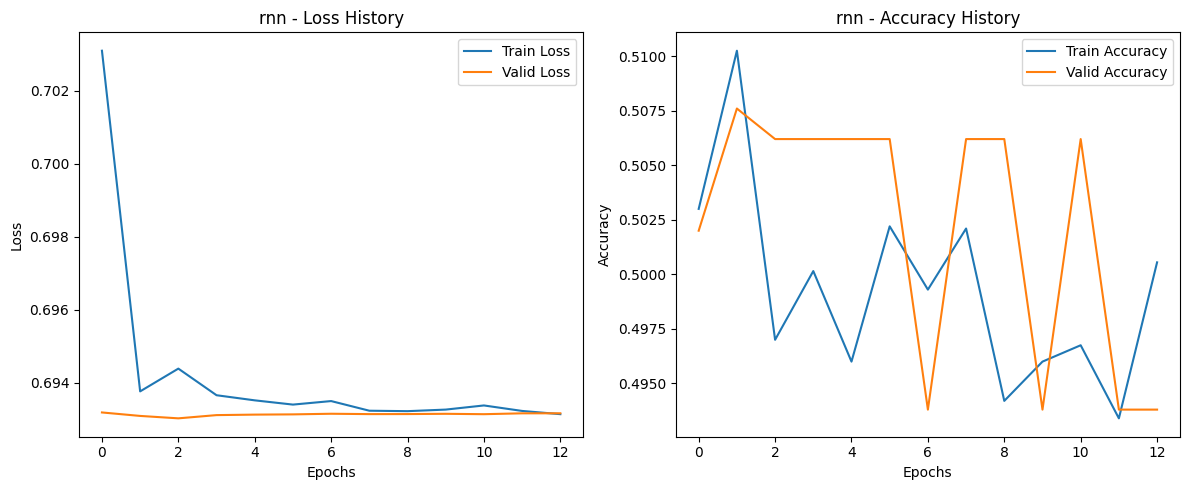

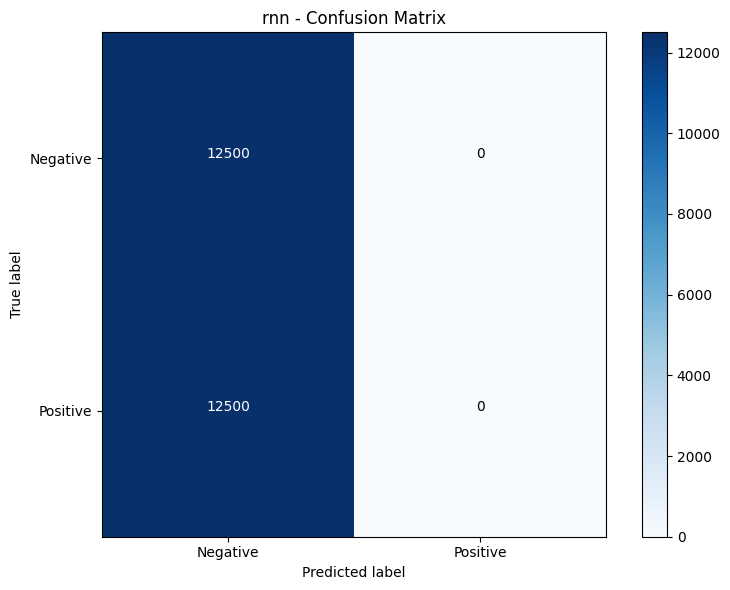

In [61]:
# Plotting hasil pelatihan
plot_training_history(history_rnn, "rnn")

# Plotting confusion matrix
plot_confusion_matrix(y_test, result_rnn['y_pred'], "rnn")

## 5. Menyimpan Model

In [62]:
# Menyimpan model
model_rnn.save('model_tensorflow_rnn.keras')
print("Model RNN disimpan sebagai 'model_rnn.keras'")

Model RNN disimpan sebagai 'model_rnn.keras'


# B. LSTM dengan Tensorflow

## 1. Menyusun Model LSTM


In [37]:
# Fungsi untuk membuat model LSTM kompleks
def build_lstm_model():
    model = Sequential([
        Input(shape=(MAXLEN,)),
        Embedding(NUM_WORDS, EMBEDDING_DIM),

        LSTM(HIDDEN_DIM, return_sequences=True),
        LSTM(HIDDEN_DIM // 2, return_sequences=False),

        Dense(HIDDEN_DIM // 4, activation='relu'),
        Dropout(DROPOUT_RATE),
        Dense(1, activation='sigmoid')
    ])
    
    return model

# inisialisasi model
model_lstm = build_lstm_model()

## 2. Melatih Model

In [38]:
# Menyusun model
model_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Melatih model LSTM
print("Melatih model LSTM...")
history_lstm = train_model(model_lstm, train_data, 'lstm')

Melatih model LSTM...
Memulai pelatihan model lstm...
Epoch 1/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 80s 498ms/step - accuracy: 0.5038 - loss: 0.6935 - val_accuracy: 0.5040 - val_loss: 0.6926
Epoch 2/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 76s 486ms/step - accuracy: 0.5352 - loss: 0.6835 - val_accuracy: 0.5276 - val_loss: 0.6898
Epoch 3/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 77s 489ms/step - accuracy: 0.5504 - loss: 0.6614 - val_accuracy: 0.5260 - val_loss: 0.7211
Epoch 4/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 78s 496ms/step - accuracy: 0.5668 - loss: 0.6216 - val_accuracy: 0.5522 - val_loss: 0.7339
Epoch 5/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 78s 495ms/step - accuracy: 0.6764 - loss: 0.5709 - val_accuracy: 0.7466 - val_loss: 0.5839
Epoch 6/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 79s 502ms/step - accuracy: 0.8085 - loss: 0.4805 - val_accuracy: 0.7688 - val_loss: 0.5383
Epoch 7/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 78s 496ms/step - accuracy: 0.8584 - loss: 0.3644 - val_accuracy: 0.7970 - val_loss: 0.4971
Epoch 8/20
157/157 ━━━━━━━━━━

## 3. Mengevaluasi Model dengan Menghitung Akurasi, Presisi, Recall, F1Squared, ROC, dan AUC-ROC

In [39]:
# Evaluasi model LSTM
result_lstm = evaluate_model(model_lstm, test_data, 'lstm')

782/782 ━━━━━━━━━━━━━━━━━━━━ 33s 42ms/step

Evaluasi Model lstm:
Accuracy: 0.8444
Precision: 0.8541
Recall: 0.8306
F1 Score: 0.8422
AUC: 0.9126


## 4. Memvisualisasikan Prediksi dari model yang telah dilatih

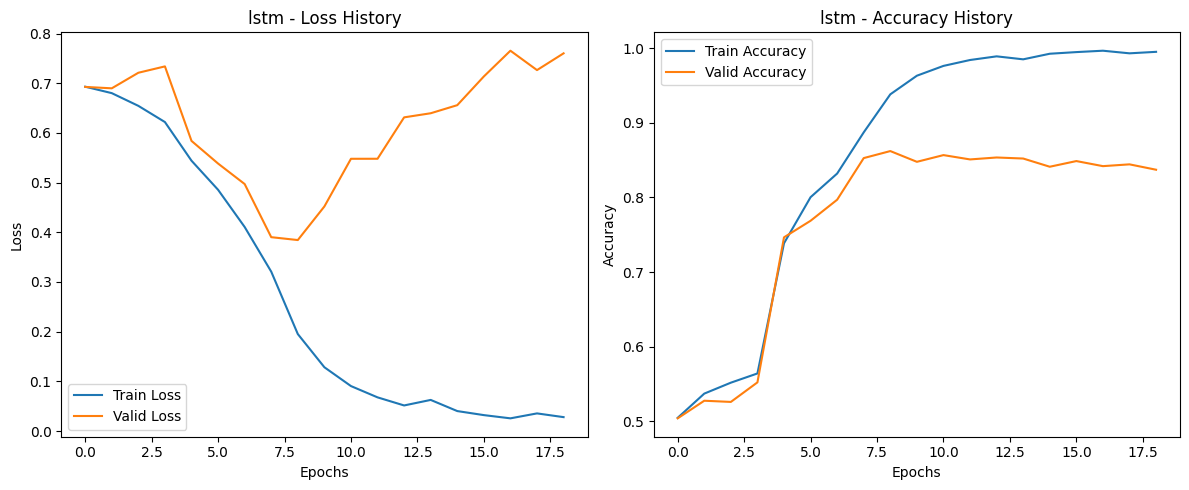

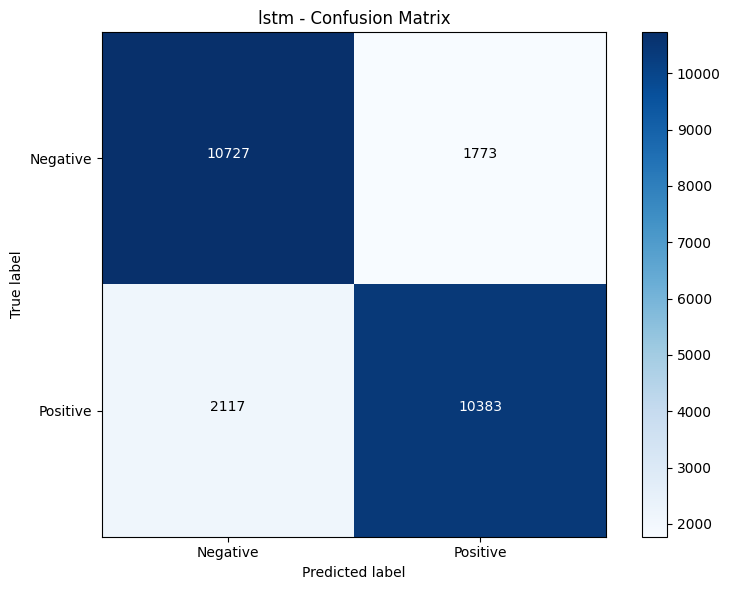

In [54]:
# Plotting hasil pelatihan
plot_training_history(history_lstm, "lstm")

# Plotting confusion matrix
plot_confusion_matrix(y_test, result_lstm['y_pred'], "lstm")

## 5. Menyimpan Model

In [43]:
# Menyimpan model
model_lstm.save('model_tensorflow_lstm.keras')
print("Model LSTM disimpan sebagai 'model_tensorflow_lstm.keras'")

Model LSTM disimpan sebagai 'model_tensorflow_lstm.keras'


# C. GRU dengan Tensorflow

## 1. Menyusun Model GRU


In [46]:
# Fungsi untuk membuat model GRU kompleks
def build_gru_model():
    model = Sequential([
        Input(shape=(MAXLEN,)),
        Embedding(NUM_WORDS, EMBEDDING_DIM),
        
        GRU(HIDDEN_DIM, return_sequences=True),
        GRU(HIDDEN_DIM // 2, return_sequences=False),

        Dense(HIDDEN_DIM // 4, activation='relu'),
        Dropout(DROPOUT_RATE),
        Dense(1, activation='sigmoid')
    ])
    
    return model

# inisialisasi model
model_gru = build_gru_model()

## 2. Melatih Model

In [47]:
# Menyusun model
model_gru.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Melatih model GRU
print("Melatih model gru...")
history_gru = train_model(model_gru, train_data, 'gru')

Melatih model gru...
Memulai pelatihan model gru...
Epoch 1/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 76s 474ms/step - accuracy: 0.5055 - loss: 0.6934 - val_accuracy: 0.5116 - val_loss: 0.6929
Epoch 2/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 73s 466ms/step - accuracy: 0.5321 - loss: 0.6843 - val_accuracy: 0.5172 - val_loss: 0.6931
Epoch 3/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 74s 468ms/step - accuracy: 0.5493 - loss: 0.6582 - val_accuracy: 0.5132 - val_loss: 0.7155
Epoch 4/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 72s 460ms/step - accuracy: 0.5680 - loss: 0.6219 - val_accuracy: 0.8080 - val_loss: 0.5724
Epoch 5/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 73s 464ms/step - accuracy: 0.8567 - loss: 0.4593 - val_accuracy: 0.8292 - val_loss: 0.5197
Epoch 6/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 73s 467ms/step - accuracy: 0.9219 - loss: 0.2331 - val_accuracy: 0.8664 - val_loss: 0.3557
Epoch 7/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 73s 464ms/step - accuracy: 0.9742 - loss: 0.0915 - val_accuracy: 0.8554 - val_loss: 0.5029
Epoch 8/20
157/157 ━━━━━━━━━━━━

## 3. Mengevaluasi Model dengan Menghitung Akurasi, Presisi, Recall, F1Squared, ROC, dan AUC-ROC

In [48]:
# Evaluasi model GRU
print("Evaluasi model GRU...")
result_gru = evaluate_model(model_gru, test_data, 'gru')

Evaluasi model GRU...
782/782 ━━━━━━━━━━━━━━━━━━━━ 29s 37ms/step

Evaluasi Model gru:
Accuracy: 0.8517
Precision: 0.8707
Recall: 0.8261
F1 Score: 0.8478
AUC: 0.9174


## 4. Memvisualisasikan Prediksi dari model yang telah dilatih

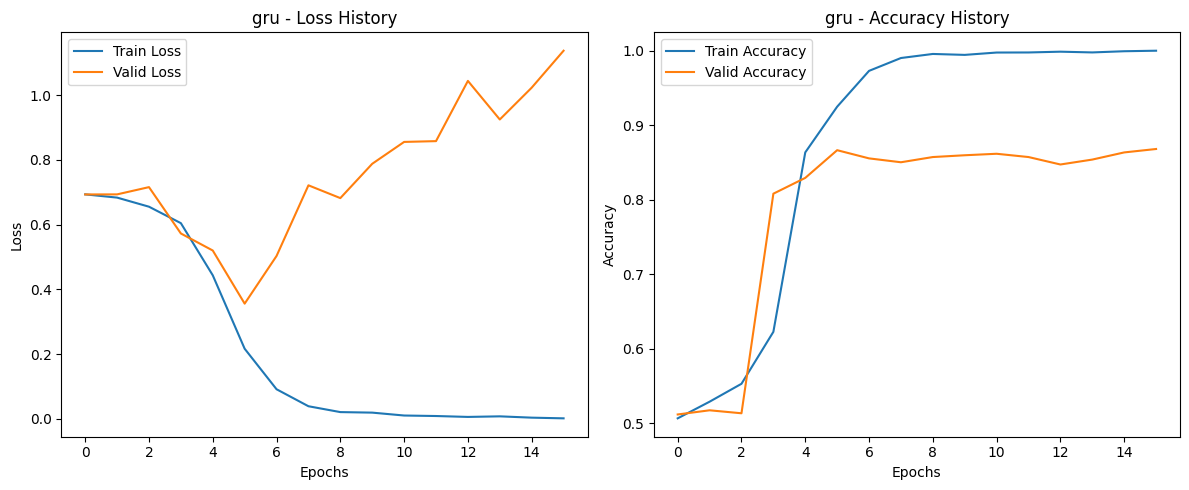

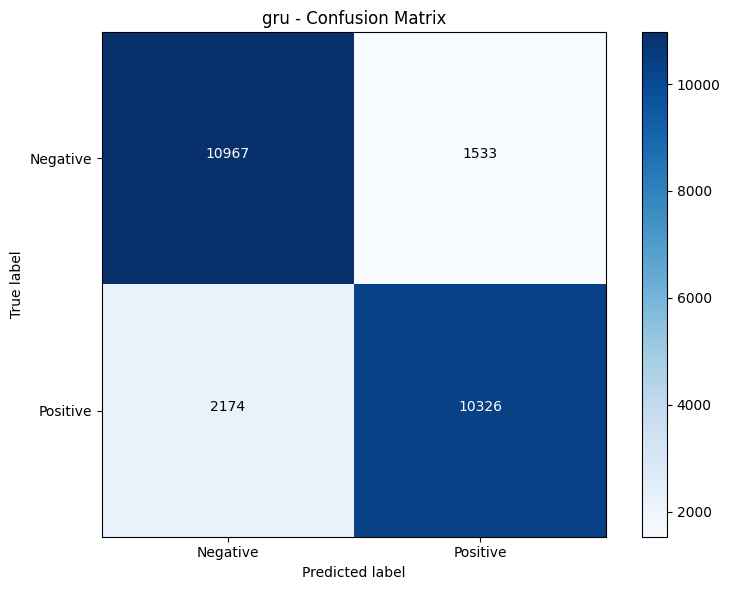

In [55]:
# Plotting hasil pelatihan
plot_training_history(history_gru, "gru")

# Plotting confusion matrix
plot_confusion_matrix(y_test, result_gru['y_pred'], "gru")

## 5. Menyimpan Model

In [50]:
# Menyimpan model
model_gru.save('model_tensorflow_gru.keras')
print("Model GRU disimpan sebagai 'model_tenosrflow_gru.keras'")

Model GRU disimpan sebagai 'model_tenosrflow_gru.keras'


# Perbandingan antara model

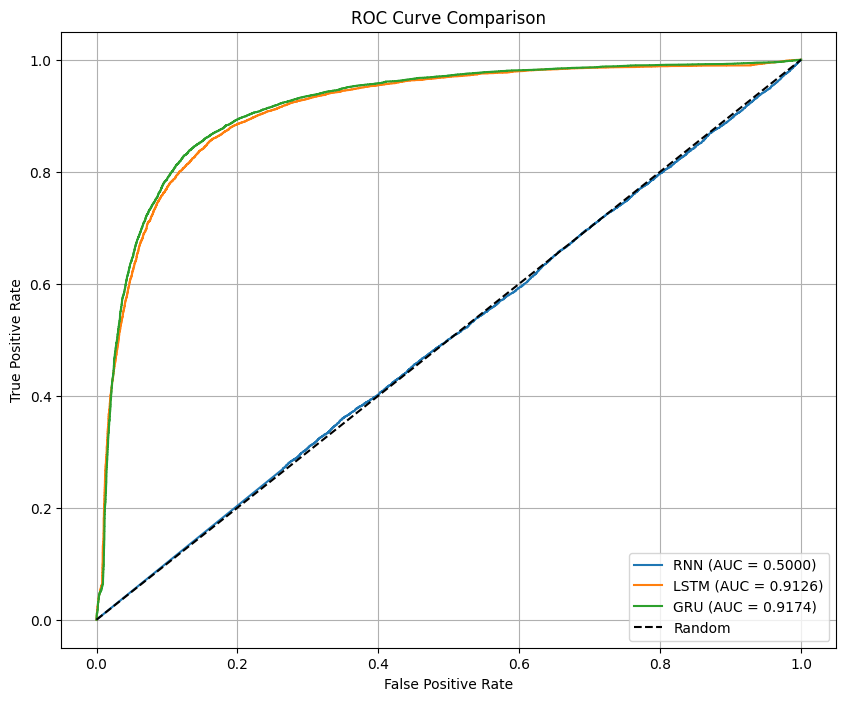

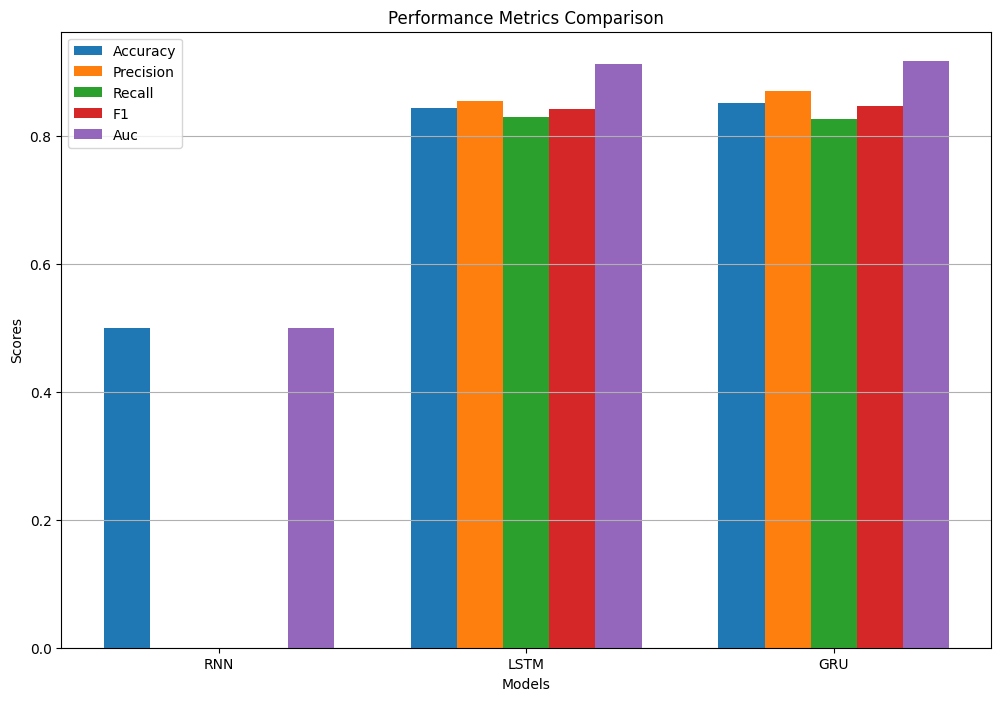

: 

In [ ]:
# Menghitung perbandingan untuk semua model
results_dict = {
    'RNN': result_rnn,
    'LSTM': result_lstm,
    'GRU': result_gru
}

# Plotting ROC curve
plot_roc_curve(results_dict)
# Plotting perbandingan metrik
plot_metrics_comparison(results_dict)